# Prediction of weather impacted flight delay

## Importing libraries

In [1]:
pip install selenium

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

from datetime import datetime, timedelta
import concurrent.futures
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import os
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import SelectKBest, mutual_info_classif

As the data collection section takes time, you can skip it until the reproducibility section, as the data collected is already present in the technical work repository in csv format.

## Data collection

### Collect flight data from BTS

To collect BTS flight data, go to the following web page:https://transtats.bts.gov/DL_SelectFields.aspx?gnoyr_VQ=FGJ&QO_fu146_anzr=b0-gvzr

Download the data by ticking the boxes below:

FlightDate; Tail_Number; Flight_Number_Reporting_Airline; Origin; Dest; CRSDepTime;
DepTime; DepDelay; DepDel15; TaxiOut; WheelsOff; WheelsOn; TaxiIn; CRSArrTime; ArrTime;
ArrDelay; ArrDel15; Cancelled; CancellationCode; Diverted; CRSElapsedTime; ActualElapsedTime;		
AirTime; Distance; CarrierDelay; WeatherDelay; NASDelay; SecurityDelay; LateAircraftDelay

In [3]:
def merge_jfk_flight_data(year1, year2, directory, filename):
    """
    Merge flight data for JFK airport from several CSV files into a DataFrame and save it as a CSV file.

    Args:
        year1 (int): The start year of flight data collection.
        year2 (int): The end year of flight data collection.
        directory (str): Path to directory containing all flight data CSV files.
        filename (str): Filename where the merged flight data will be saved.

    Returns:
        None
    """

    # List for storing DataFrames
    dataframes_list = []

    # List of months
    months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]

    # Loop for each year and month
    for year in range(year1, year2+1):
        
        # Flight data from years during COVID-19 are not merged
        if year in (2019, 2020):
            continue
        
        for month in months:
            # Name of CSV file to be uploaded
            Flight_Data_filename = os.path.join(directory, f"T_ONTIME_REPORTING_{month}{year}.csv")
            
            if os.path.exists(Flight_Data_filename):
                # Upload the CSV file
                df_flight = pd.read_csv(Flight_Data_filename)

                # Filter for JFK airport
                df_jfk = df_flight[df_flight['ORIGIN'] == 'JFK']

                # Add to main DataFrame
                dataframes_list.append(df_jfk)
            
            else:
                print(f"File not found : {Flight_Data_filename}")
                
    if dataframes_list:
        
        # Combine all DataFrames
        df_combined = pd.concat(dataframes_list, ignore_index=True)

        # Save the combined DataFrame as a CSV file
        df_combined.to_csv(filename, index=False)

        print("The combined data was successfully saved.")
    else:
        print("No files were found and processed.")

In [4]:
merge_jfk_flight_data(2010,2023,"Chandrakumar_s419255_Data_Collected_MScCSTE","Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Flight_Data_2010_2023.csv")

The combined data was successfully saved.


### Collect weather data from Weather Underground

Functions used for converting units of measurement for variables

In [5]:
def fahrenheit_to_celsius(f):
    """
    Converts the temperature from Fahrenheit to Celsius.
    
    Args:
        f (int): Temperature in Fahrenheit.
    
    Returns:
        int: Temperature converted to Celsius.
    """
    if f == 0:
        return 0
    return round((f - 32) * 5.0 / 9.0) 

def inches_to_mm(inches):
    """
    Converts inches to millimetres.

    Args:
        inches (float): Measurement in inches.

    Returns:
        int: Measurement in millimetres and rounded.
    """
    return round(inches * 25.4)

def inches_mercury_to_hpa(inches):
    """
    Converts pressure from inches of mercury to hectopascals.

    Args:
        inches (float): Pressure in inches of mercury.

    Returns:
        float: Pressure in hectopascals and rounded.
    """
    return round(inches * 33.8639, 2)

def mph_to_kmh(mph):
    """
    Converts speed from miles per hour to kilometers per hour.

    Args:
        mph (float): Speed in miles per hour.

    Returns:
        int: Speed in kilometers per hour and rounded.
    """
    return round(mph * 1.609344)

def weather_data_into_dataframe(data, date):
    """
    Converts raw weather data into a structured DataFrame.

    Args:
        data (list of lists): Raw weather data where each sublist represents a row of data.
        date (str): The date in YYYY-MM-DD format related to the data.

    Returns:
        pd.DataFrame: A DataFrame with processed weather data.
    """

    # Define DataFrame column headers
    headers = ["DateTime", "Temperature (°C)", "Dew Point (°C)", "Humidity (%)", "Wind", 
               "Wind Speed (km/h)", "Wind Gust (km/h)", "Pressure (hPa)", "Precip. (mm)", "Condition"]

    df = pd.DataFrame(data, columns=headers)

    # Remove data unit symbols from all data
    df['Temperature (°C)'] = df['Temperature (°C)'].str.replace('°F', '').astype(int)  
    df['Dew Point (°C)'] = df['Dew Point (°C)'].str.replace('°F', '').astype(int)      
    df['Humidity (%)'] = df['Humidity (%)'].str.replace('°%', '').astype(int)        
    df['Wind Speed (km/h)'] = df['Wind Speed (km/h)'].str.replace('°mph', '').astype(float)  
    df['Wind Gust (km/h)'] = df['Wind Gust (km/h)'].str.replace('°mph', '').astype(float)    
    df['Pressure (hPa)'] = df['Pressure (hPa)'].str.replace('°in', '').astype(float)  
    df['Precip. (mm)'] = df['Precip. (mm)'].str.replace('°in', '').astype(float)     

    # Apply conversion functions to data columns
    df["Temperature (°C)"] = df["Temperature (°C)"].apply(fahrenheit_to_celsius) 
    df["Dew Point (°C)"] = df["Dew Point (°C)"].apply(fahrenheit_to_celsius)      
    df["Wind Speed (km/h)"] = df["Wind Speed (km/h)"].apply(mph_to_kmh)          
    df["Wind Gust (km/h)"] = df["Wind Gust (km/h)"].apply(mph_to_kmh)          
    df["Pressure (hPa)"] = df["Pressure (hPa)"].apply(inches_mercury_to_hpa)    
    df["Precip. (mm)"] = df["Precip. (mm)"].apply(inches_to_mm)                  

    # For weather data collected for one day, it is possible to have the data for the day before or after.

    observation_date = datetime.strptime(date, "%Y-%m-%d")
    
    # Create a list to store adjusted datetimes
    dates = []
    current_date = observation_date
    day_transition = 0
    
    # Iterate on the data to adjust the datetimes
    for i, time in enumerate(df["DateTime"]):
        
        if i == 0 and "PM" in time:
            # If the first entry contains PM, adjust to the previous date
            current_date -= timedelta(days=1)

        elif day_transition == 0 and "AM" in time:
            # If the time value contains AM for the first entry or for just
            # after the first entry, reset the date to the current date.
            day_transition = 1
            current_date = observation_date

        elif day_transition == 1 and "AM" in time and "PM" in df["DateTime"][i - 1]:
            # If we change from PM to AM, adjust the date by one day
            current_date += timedelta(days=1)

        # Add corrected datetimes to the list
        dates.append(current_date.strftime("%Y-%m-%d") + " " + time)

    # Update the DateTime column with the new values
    df["DateTime"] = pd.to_datetime(dates)

    return df



Collection of weather data for a specific date

In [6]:
def collect_weather_data_for_date(date):
    """
    Collects weather data for a specific date from the Weather Underground site.
    
    Args:
        date (str): Date in YYYY-MM-DD format.
    
    Returns:
        pd.DataFrame: A DataFrame containing the weather data for the specific date.
    """
    
    # URL to collect weather data for the specified date
    url = 'https://www.wunderground.com/history/daily/us/ny/new-york-city/KJFK/date/' + date
    #print(url)
    
    # Configuration of selenium package objects to access the page via the URL
    options = webdriver.FirefoxOptions()
    options.add_argument('--headless')
    driver = webdriver.Firefox(options=options)
    
    driver.get(url)

    # Wait for the weather data table to appear
    wait = WebDriverWait(driver, 60)
    table = wait.until(EC.presence_of_element_located((By.XPATH, "//table[contains(@class, 'mat-table cdk-table mat-sort ng-star-inserted')]")))

    rows = []
    table_rows = table.find_elements(By.XPATH, ".//tbody/tr[contains(@class,'mat-row cdk-row ng-star-inserted')]")

    # Extraction of weather data from each row of the table
    for table_row in table_rows:
        data = []
        table_columns = table_row.find_elements(By.XPATH, ".//td")
        for table_column in table_columns:
            value = table_column.get_attribute('textContent')
            data.append(value)
        rows.append(data)
    
    driver.quit()
    
    # Converting weather data into DataFrame
    df = weather_data_into_dataframe(rows, date)

    return df

Collection of weather data for a specific month and year

In [7]:
def collect_weather_data(month, year):
    """
    Collects weather data for a specific month and year.
    
    Args:
        month (int): Month for which weather data is to be collected.
        year (int): Year for which weather data is to be collected.
    
    Returns:
        pd.DataFrame:  A DataFrame containing the weather data for the specific month and year.
    """
    # List of months
    months = ["JAN", "FEB", "MAR", "APR", "MAY", "JUN", "JUL", "AUG", "SEP", "OCT", "NOV", "DEC"]

    # Define the start and end dates for each month
    start_date = datetime(year, month, 1)
    
    if month == 12:
        end_date = datetime(year + 1, 1, 1) - timedelta(days=1)
    else:
        end_date = datetime(year, month + 1, 1) - timedelta(days=1)
        
    # Store all dates for the month
    dates = [(start_date + timedelta(days=i)).strftime('%Y-%m-%d') for i in range((end_date - start_date).days + 1)]

    weather_data = []
    
    # Collect weather data for each date using multithreading to speed up the process
    with concurrent.futures.ThreadPoolExecutor(max_workers=3) as executor:  
        futures = [executor.submit(collect_weather_data_for_date, date) for date in dates]
        for future in concurrent.futures.as_completed(futures):
            df_weather = future.result()
            if not df_weather.empty:
                weather_data.append(df_weather)

    # Combine the weather data for each day of the month in a DataFrame
    df_weather_month = pd.concat(weather_data, ignore_index=True)
    df_weather_month = df_weather_month.sort_values(by="DateTime")
    
    # Save weather data in a CSV file
    output_filename = f'Chandrakumar_s419255_Data_MScCSTE/WEATHER_DATA_KJFK_{months[month-1]}{year}.csv'
    df_weather_month.to_csv(output_filename, index=False)
    
    print(f'Data for {year}-{month:02} saved in {output_filename}')
    
    return df_weather_month

In [ ]:
# Execution of weather data collection 
years = range(2009, 2010) # Year values can be changed
dataframe = []

for year in years:
    # Weather data from years during COVID-19 are not collected
    if year in (2019, 2020):
        continue 
    
    for i in range(12, 13): # Month values can be changed
        dataframe.append(collect_weather_data(i, year))

# It is better to collect weather data 6 months at a time to prevent the code from crashing.

In [8]:
def merge_jfk_weather_data(year1, year2, directory, filename):
    """
    Merge weather data for JFK airport from several CSV files into a DataFrame and save it as a CSV file.

    Args:
        year1 (int): The start year of weather data collection.
        year2 (int): The end year of weather data collection.
        directory (str): Path to directory containing all weather data CSV files.
        filename (str): Filename where the merged weather data will be saved.

    Returns:
        None
    """

    # List for storing DataFrames
    dataframes_list = []

    # List of months
    months = ["JAN","FEB","MAR","APR","MAY","JUN","JUL","AUG","SEP","OCT","NOV","DEC"]

    # Loop for each year and month
    for year in range(year1, year2+1):
        
        # Weather data from years during COVID-19 are not merged
        if year in (2019, 2020):
            continue
        
        for month in months:
            # Name of CSV file to be uploaded
            Weather_Data_filename = os.path.join(directory, f"WEATHER_DATA_KJFK_{month}{year}.csv")
            
            if os.path.exists(Weather_Data_filename):
                # Upload the CSV file
                df_weather = pd.read_csv(Weather_Data_filename)

                # Add to main DataFrame
                dataframes_list.append(df_weather)
            
            else:
                print(f"File not found : {Weather_Data_filename}")
                
    if dataframes_list:
        
        # Combine all DataFrames
        df_combined = pd.concat(dataframes_list, ignore_index=True)

        # Save the combined DataFrame as a CSV file
        df_combined.to_csv(filename, index=False)

        print("The combined data was successfully saved.")
    else:
        print("No files were found and processed.")

In [9]:
merge_jfk_weather_data(2009,2023,"Chandrakumar_s419255_Data_Collected_MScCSTE","Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Weather_Data_2010_2023.csv")

File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_JAN2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_FEB2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_MAR2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_APR2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_MAY2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_JUN2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_JUL2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_AUG2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_SEP2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_OCT2009.csv
File not found : Chandrakumar_s419255_Data_Collected_MScCSTE\WEATHER_DATA_KJFK_NOV2009.csv

## Merging flight and weather data

In [10]:
def convert_to_time_format(val):
    """
    Converts a Time value into HH:MM format.
    
    Args:
        val (float): Time value in military format or NaN.
    
    Returns:
        str: Time in HH:MM format or None if the value is NaN.
    """
    # Check if the value is NaN
    if pd.isnull(val):
        return None
    
    hours = int(val) // 100
    minutes = int(val) % 100

    # If the hours are equal to 24, set them to 0
    if hours == 24:
        hours = 0

    # Format Time in HH:MM using two digits for hours and minutes
    return f"{hours:02d}:{minutes:02d}"

def convert_to_datetime(date, time):
    """
    Combines a date and a time.
    
    Args:
        date (str): Date value into YYYY-MM-DD format.
        time (str): Time value into HH:MM format or None.
    
    Returns:
        pd.Timestamp: Datetime object corresponding to the time and date combination.
    """
    # Check if the value is NaN
    if pd.isnull(time):
        return None
    
    # Combine date and time
    return pd.to_datetime(f"{date} {time}")

def merge_flight_weather_data(filename1, filename2, timing):
    """
    Merges flight data with weather data into a DataFrame and save it as a CSV file.
    
    Args:
        filename1 (str): Path to CSV file containing flight data.
        filename2 (str): Path to CSV file containing weather data.
        timing (int): Timing of weather data collected before the scheduled flight departure.
    
    Returns:
        pd.DataFrame: a DataFrame merged with flight data and associated weather data.
    """
    print(timing)
    # Check if the files exist
    if os.path.exists(filename1) and os.path.exists(filename2):
        
        df_flight = pd.read_csv(filename1)
        df_flight['FL_DATE'] = pd.to_datetime(df_flight['FL_DATE']).dt.date
        
        # Convert time to HH:MM format
        df_flight['CRS_DEP_TIME_1'] = df_flight.apply(lambda row: convert_to_time_format(row['CRS_DEP_TIME']), axis=1)

        df_weather = pd.read_csv(filename2)

        # Create or convert a datetime column for flight and weather data
        df_flight["FlightDateTime"] = df_flight.apply(lambda row: convert_to_datetime(row['FL_DATE'], row['CRS_DEP_TIME_1']), axis=1)
        df_weather["DateTime"] = pd.to_datetime(df_weather["DateTime"])
        
        df_flight[f"FlightDateTime_minus_{timing}h"] = df_flight["FlightDateTime"] - pd.Timedelta(hours=timing)

        # Sort DataFrames by datetime
        df_flight = df_flight.sort_values(f"FlightDateTime_minus_{timing}h")
        df_weather = df_weather.sort_values('DateTime')

        # Merge flight and weather data according to the given timing
        if timing == 0:
            # No tolerance required
            flight_weather_data = pd.merge_asof(df_flight, df_weather, left_on=f"FlightDateTime_minus_{timing}h", 
                                                right_on='DateTime', direction='backward')
        else:
            # With tolerance
            flight_weather_data = pd.merge_asof(df_flight, df_weather, left_on=f"FlightDateTime_minus_{timing}h", 
                                                right_on='DateTime', direction='backward',tolerance=pd.Timedelta(hours=timing))

        # Deletes columns used just for merging
        flight_weather_data.drop(columns=["FlightDateTime", f"FlightDateTime_minus_{timing}h", "DateTime","CRS_DEP_TIME_1"], inplace=True)
        
        output_file = f"Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Flight_Weather_Data_2010_2023_{timing}h.csv"
        flight_weather_data.to_csv(output_file, index=False)
        

In [11]:
filename1 = "Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Flight_Data_2010_2023.csv"
filename2 = "Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Weather_Data_2010_2023.csv"
timings = [0, 2, 4, 8, 16, 24, 48]

for timing in timings:  
    merge_flight_weather_data(filename1, filename2, timing)

0
2
4
8
16
24
48


## Reproducibility

In [12]:
# Fixed random seed for reproducibility of results
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print(RANDOM_SEED)

42


The cells in the Jupiter Notebook file must be run in chronological order to ensure reproducible results.

## Data Preprocessing

The timing of the weather data can be changed (0h, 2h, 4h, 8h, 16h, 24h or 48h before flight departure)

In [13]:
timing = 0
# timing = 2
# timing = 4
# timing = 8 
# timing = 16
# timing = 24
# timing = 48

In [14]:
df = pd.read_csv(f"Chandrakumar_s419255_Data_Merged_MScCSTE/JFK_Flight_Weather_Data_2010_2023_{timing}h.csv")
#df = pd.read_csv("C:/Users/moi/OneDrive - etu.utc.fr/Bureau/UTC/Cranfield/Thesis/Code/JFK_Flight_Weather_Data_2010_2023_0.csv")
df

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,LATE_AIRCRAFT_DELAY,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition
0,2010-01-01,AA,N5FTAA,1155,JFK,MIA,545,557.0,12.0,0.0,...,NaN,1,0,96,CALM,0,0,1014.22,0,Cloudy
1,2010-01-01,B6,N640JB,63,JFK,TPA,600,558.0,-2.0,0.0,...,0.0,1,-1,92,CALM,0,0,1013.89,0,Cloudy
2,2010-01-01,B6,N634JB,735,JFK,BQN,600,552.0,-8.0,0.0,...,NaN,1,-1,92,CALM,0,0,1013.89,0,Cloudy
3,2010-01-01,B6,N521JB,701,JFK,SJU,600,611.0,11.0,0.0,...,NaN,1,-1,92,CALM,0,0,1013.89,0,Cloudy
4,2010-01-01,B6,N706JB,983,JFK,FLL,600,604.0,4.0,0.0,...,0.0,1,-1,92,CALM,0,0,1013.89,0,Cloudy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1291666,2023-12-31,B6,N957JB,1803,JFK,SJU,2129,2120.0,-9.0,0.0,...,NaN,6,-3,55,W,14,0,1015.92,0,Cloudy
1291667,2023-12-31,B6,N566JB,1053,JFK,PBI,2150,2243.0,53.0,1.0,...,6.0,6,-3,55,W,14,0,1015.92,0,Cloudy
1291668,2023-12-31,B6,N994JL,403,JFK,SJU,2255,2345.0,50.0,1.0,...,38.0,6,-2,60,W,11,0,1015.92,0,Cloudy
1291669,2023-12-31,B6,N793JB,745,JFK,PSE,2259,2248.0,-11.0,0.0,...,NaN,6,-2,60,W,11,0,1015.92,0,Cloudy


In [15]:
# Replace military times 2400.0 with 0.0 to indicate midnight
for column in ["DEP_TIME","WHEELS_OFF","WHEELS_ON","CRS_ARR_TIME","ARR_TIME"]:
    df.loc[df[column] == 2400.0, column] = 0.0

### Handling Missing Values

In [16]:
# Display a summary of the DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1291671 entries, 0 to 1291670
Data columns (total 39 columns):
 #   Column               Non-Null Count    Dtype  
---  ------               --------------    -----  
 0   FL_DATE              1291671 non-null  object 
 1   OP_UNIQUE_CARRIER    1291671 non-null  object 
 2   TAIL_NUM             1288409 non-null  object 
 3   OP_CARRIER_FL_NUM    1291671 non-null  int64  
 4   ORIGIN               1291671 non-null  object 
 5   DEST                 1291671 non-null  object 
 6   CRS_DEP_TIME         1291671 non-null  int64  
 7   DEP_TIME             1263113 non-null  float64
 8   DEP_DELAY            1263039 non-null  float64
 9   DEP_DEL15            1263039 non-null  float64
 10  TAXI_OUT             1261846 non-null  float64
 11  WHEELS_OFF           1261846 non-null  float64
 12  WHEELS_ON            1261513 non-null  float64
 13  TAXI_IN              1261513 non-null  float64
 14  CRS_ARR_TIME         1291671 non-null  int64  
 15

In [22]:
# Determine the number of missing values for each column in the DataFrame
df.isnull().sum()

FL_DATE                0
OP_UNIQUE_CARRIER      0
TAIL_NUM               0
OP_CARRIER_FL_NUM      0
ORIGIN                 0
DEST                   0
CRS_DEP_TIME           0
DEP_TIME               0
DEP_DELAY              0
DEP_DEL15              0
TAXI_OUT               0
WHEELS_OFF             0
WHEELS_ON              0
TAXI_IN                0
CRS_ARR_TIME           0
ARR_TIME               0
ARR_DELAY              0
ARR_DEL15              0
CRS_ELAPSED_TIME       0
ACTUAL_ELAPSED_TIME    0
AIR_TIME               0
DISTANCE               0
CARRIER_DELAY          0
WEATHER_DELAY          0
NAS_DELAY              0
SECURITY_DELAY         0
LATE_AIRCRAFT_DELAY    0
Temperature (°C)       0
Dew Point (°C)         0
Humidity (%)           0
Wind                   0
Wind Speed (km/h)      0
Wind Gust (km/h)       0
Pressure (hPa)         0
Precip. (mm)           0
Condition              0
dtype: int64

Removing unnecessary data

In [18]:
# Keep only flights that are not diverted or cancelled
df = df[(df['DIVERTED'] == 0) & (df['CANCELLED'] == 0)].reset_index(drop=True)

# Keep only rows where the Condition column contains no missing values
df = df[df["Condition"].notna()].reset_index(drop=True)

# Remove unnecessary columns from the DataFrame
df = df.drop(['DIVERTED','CANCELLED','CANCELLATION_CODE'], axis=1)

Replace missing values with specific ones

In [19]:
# Replace the missing values by 0 for the columns associated with the departure/arrival delay, 
# as it can be seen that the missing values are present when the scheduled departure/arrival time 
# is the same as the actual departure/arrival time.
for column in ['ARR_DELAY','ARR_DEL15','DEP_DELAY','DEP_DEL15']:
    df.loc[df[column].isna(), column] = 0.0

# Replace missing values with 0 for delay columns, as missing values are present when flights 
# arrive on time.
for column in ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY','LATE_AIRCRAFT_DELAY']:
    df.loc[df['ARR_DEL15'] == 0.0, column] = 0.0

# Replace the missing values by CALM for the Wind column, as the missing values are present
# when the wind speed or wind gust is equal to 0.
df.loc[df["Wind"].isna(), "Wind"] = "CALM"

#### Convert DataFrame object columns

In [20]:
# Convert specified DataFrame columns to string format
df['ORIGIN'] = df['ORIGIN'].convert_dtypes()
df['DEST'] = df['DEST'].convert_dtypes()
df['OP_UNIQUE_CARRIER'] = df['OP_UNIQUE_CARRIER'].convert_dtypes()
df['Wind'] = df['Wind'].convert_dtypes()
df['Condition'] = df['Condition'].convert_dtypes()
df['TAIL_NUM'] = df['TAIL_NUM'].convert_dtypes()

In [21]:
# Convert FL_DATE column in the DataFrame to datetime format
df['FL_DATE'] = pd.to_datetime(df['FL_DATE'])

### Target variable creation

In [26]:
# Sets the STATUS column to 0 to indicate that the flight is on-time
df['STATUS'] = 0 

# Sets the STATUS column to 1 for delayed flights with no weather delay.
df.loc[(df['WEATHER_DELAY'] == 0.0) & (df['ARR_DEL15'] == 1.0), 'STATUS'] = 1 

# Sets the STATUS column to 2 for flights delayed due to weather conditions
df.loc[(df['WEATHER_DELAY'] > 0.0) & (df['ARR_DEL15'] == 1.0), 'STATUS'] = 2 

df

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
0,2010-01-01,OH,N924CA,6566,JFK,ALB,1840,1836.0,-4.0,0.0,...,4,0,76,N,10,0,1009.48,0,Mostly Cloudy,0
1,2010-01-01,DL,N6712B,1297,JFK,ATL,600,557.0,-3.0,0.0,...,1,-1,92,CALM,0,0,1013.89,0,Cloudy,0
2,2010-01-01,DL,N929DL,1641,JFK,ATL,820,845.0,25.0,1.0,...,1,0,93,SW,5,0,1013.89,0,Cloudy,1
3,2010-01-01,DL,N905DL,1723,JFK,ATL,1100,1053.0,-7.0,0.0,...,2,0,89,WSW,10,0,1012.87,0,Cloudy,0
4,2010-01-01,DL,N946DL,1737,JFK,ATL,1350,1351.0,1.0,0.0,...,3,1,86,WSW,8,0,1011.18,0,Mostly Cloudy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258492,2023-12-31,B6,N238JB,2725,JFK,TPA,1030,1028.0,-2.0,0.0,...,5,-4,53,NW,23,0,1015.24,0,Mostly Cloudy,0
1258493,2023-12-31,DL,N870DN,1241,JFK,TPA,1133,1124.0,-9.0,0.0,...,6,-4,51,WNW,24,0,1015.92,0,Mostly Cloudy,0
1258494,2023-12-31,B6,N3115J,125,JFK,TPA,1230,1231.0,1.0,0.0,...,6,-4,51,WNW,24,0,1015.24,0,Mostly Cloudy,0
1258495,2023-12-31,B6,N593JB,2825,JFK,TPA,1700,1657.0,-3.0,0.0,...,6,-4,51,W,19,0,1014.56,0,Mostly Cloudy,0


### Exploratory Data Analysis (EDA)

In [27]:
df = df.sort_values(by=['FL_DATE','DEST', 'CRS_DEP_TIME']).reset_index(drop=True)
df

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
0,2010-01-01,OH,N924CA,6566,JFK,ALB,1840,1836.0,-4.0,0.0,...,4,0,76,N,10,0,1009.48,0,Mostly Cloudy,0
1,2010-01-01,DL,N6712B,1297,JFK,ATL,600,557.0,-3.0,0.0,...,1,-1,92,CALM,0,0,1013.89,0,Cloudy,0
2,2010-01-01,DL,N929DL,1641,JFK,ATL,820,845.0,25.0,1.0,...,1,0,93,SW,5,0,1013.89,0,Cloudy,1
3,2010-01-01,DL,N905DL,1723,JFK,ATL,1100,1053.0,-7.0,0.0,...,2,0,89,WSW,10,0,1012.87,0,Cloudy,0
4,2010-01-01,DL,N946DL,1737,JFK,ATL,1350,1351.0,1.0,0.0,...,3,1,86,WSW,8,0,1011.18,0,Mostly Cloudy,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258492,2023-12-31,B6,N238JB,2725,JFK,TPA,1030,1028.0,-2.0,0.0,...,5,-4,53,NW,23,0,1015.24,0,Mostly Cloudy,0
1258493,2023-12-31,DL,N870DN,1241,JFK,TPA,1133,1124.0,-9.0,0.0,...,6,-4,51,WNW,24,0,1015.92,0,Mostly Cloudy,0
1258494,2023-12-31,B6,N3115J,125,JFK,TPA,1230,1231.0,1.0,0.0,...,6,-4,51,WNW,24,0,1015.24,0,Mostly Cloudy,0
1258495,2023-12-31,B6,N593JB,2825,JFK,TPA,1700,1657.0,-3.0,0.0,...,6,-4,51,W,19,0,1014.56,0,Mostly Cloudy,0


In [28]:
df.describe()

,OP_CARRIER_FL_NUM,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,WHEELS_OFF,WHEELS_ON,TAXI_IN,CRS_ARR_TIME,...,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,Temperature (°C),Dew Point (°C),Humidity (%),Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),STATUS
count,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,...,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06,1.258497e+06
mean,1.532725e+03,1.382519e+03,1.380219e+03,1.292213e+01,2.112464e-01,2.646938e+01,1.409183e+03,1.496131e+03,7.526100e+00,1.540113e+03,...,4.127066e-02,4.251030e+00,1.401472e+01,6.518943e+00,6.363437e+01,1.903117e+01,8.147074e+00,1.016468e+03,9.599149e-02,2.364765e-01
std,1.663839e+03,4.885283e+02,5.114842e+02,4.681147e+01,4.081930e-01,1.434878e+01,5.238369e+02,5.796619e+02,6.230453e+00,5.596896e+02,...,1.843025e+00,2.198812e+01,9.576082e+00,1.065330e+01,2.010878e+01,9.506441e+00,1.780030e+01,1.020137e+01,7.740493e-01,4.536798e-01
min,1.000000e+00,2.500000e+01,0.000000e+00,-8.400000e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,-1.700000e+01,-2.800000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.030000e+02,9.100000e+02,9.110000e+02,-5.000000e+00,0.000000e+00,1.700000e+01,9.310000e+02,1.054000e+03,4.000000e+00,1.117000e+03,...,0.000000e+00,0.000000e+00,7.000000e+00,-2.000000e+00,4.800000e+01,1.300000e+01,0.000000e+00,1.011510e+03,0.000000e+00,0.000000e+00
50%,8.410000e+02,1.444000e+03,1.442000e+03,-2.000000e+00,0.000000e+00,2.300000e+01,1.455000e+03,1.537000e+03,6.000000e+00,1.605000e+03,...,0.000000e+00,0.000000e+00,1.400000e+01,8.000000e+00,6.400000e+01,1.900000e+01,0.000000e+00,1.016260e+03,0.000000e+00,0.000000e+00
75%,2.246000e+03,1.815000e+03,1.823000e+03,9.000000e+00,0.000000e+00,3.100000e+01,1.844000e+03,2.001000e+03,9.000000e+00,2.018000e+03,...,0.000000e+00,0.000000e+00,2.200000e+01,1.600000e+01,8.000000e+01,2.400000e+01,0.000000e+00,1.021340e+03,0.000000e+00,0.000000e+00
max,9.887000e+03,2.359000e+03,2.359000e+03,1.757000e+03,1.000000e+00,1.860000e+02,2.359000e+03,2.359000e+03,2.860000e+02,2.359000e+03,...,3.750000e+02,1.223000e+03,3.900000e+01,2.900000e+01,1.000000e+02,7.700000e+01,1.010000e+02,1.044360e+03,7.100000e+01,2.000000e+00


Distribution of different flight categories

C:\Users\moi\AppData\Local\Temp/ipykernel_53340/3753319684.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels([f'{int(y)}' for y in y_ticks])


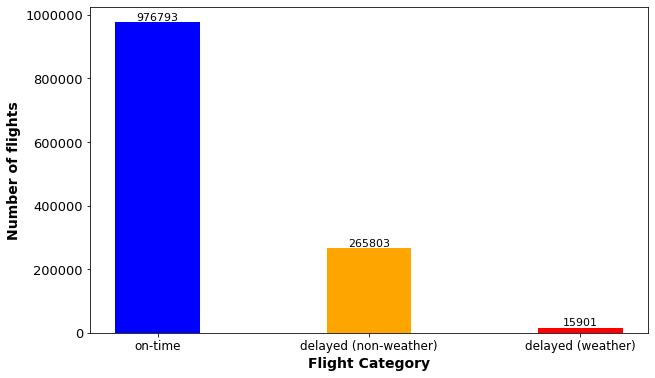

In [29]:
distribution = df["STATUS"].value_counts()

status = {0: 'on-time', 1: 'delayed (non-weather)', 2: 'delayed (weather)'}


plt.figure(figsize=(10, 6))
bars = plt.bar(distribution.index, distribution.values, color=['blue', 'orange', 'red'], width=0.4)

# Axis configuration
plt.xlabel('Flight Category', fontweight='bold', fontsize=14)
plt.ylabel('Number of flights', fontweight='bold', fontsize=14)

# Define grid 
plt.grid(axis='y', linestyle='', alpha=0.7)

# Define tick labels for the x-axis and y-axis
plt.xticks(ticks=distribution.index, labels=[status[i] for i in distribution.index], rotation=0, fontsize=12)
plt.yticks(fontsize=13)
y_ticks = plt.gca().get_yticks()
plt.gca().set_yticklabels([f'{int(y)}' for y in y_ticks])

# Add values above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=11)

plt.show()


Different types of delay

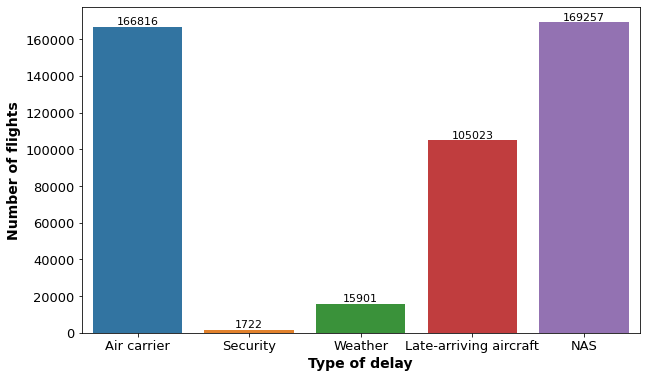

In [30]:
# Calculation of the number of samples for each type of delay
carrier_delay = (df['CARRIER_DELAY'] > 0).sum()
security_delay = (df['SECURITY_DELAY'] > 0).sum()
weather_delay = (df['WEATHER_DELAY'] > 0).sum()
late_aircraft_delay = (df['LATE_AIRCRAFT_DELAY'] > 0).sum()
NAS_delay = (df['NAS_DELAY'] > 0).sum()

# Creation of the DataFrame for delays
delay = pd.DataFrame({'Delay Type': ['Air carrier', 'Security', 'Weather', 'Late-arriving aircraft', 'NAS'],
    'Count': [carrier_delay, security_delay, weather_delay, late_aircraft_delay, NAS_delay]})

plt.figure(figsize=(10, 6))
bars = sns.barplot(x='Delay Type', y='Count', data=delay)

# Axis configuration
plt.xlabel('Type of delay', fontweight='bold', fontsize=14)
plt.ylabel('Number of flights', fontweight='bold', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

# Define grid 
plt.grid(axis='y', linestyle='', alpha=0.7)

# Adding values above the bars    
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=11)

plt.show()

Distribution of arrival flight delays

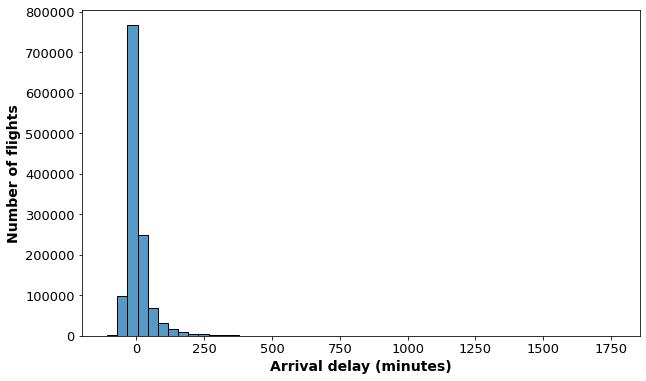

In [31]:
plt.figure(figsize=(10, 6))
sns.histplot(df['ARR_DELAY'], bins=50)

# Axis configuration
plt.xlabel('Arrival delay (minutes)', fontweight='bold', fontsize=14)
plt.ylabel('Number of flights', fontweight='bold', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

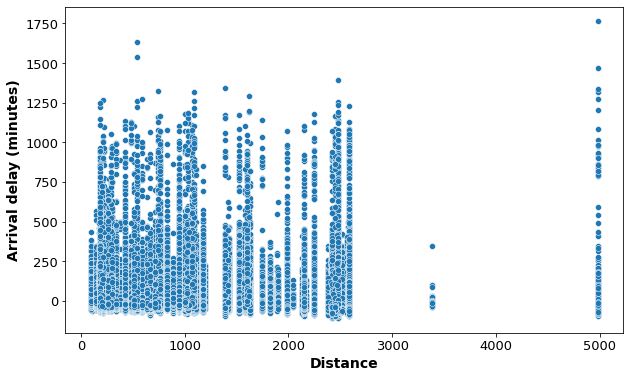

In [32]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='DISTANCE', y='ARR_DELAY', data=df)

# Axis configuration
plt.xlabel('Distance', fontweight='bold', fontsize=14)
plt.ylabel('Arrival delay (minutes)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

Distribution of weather delays 

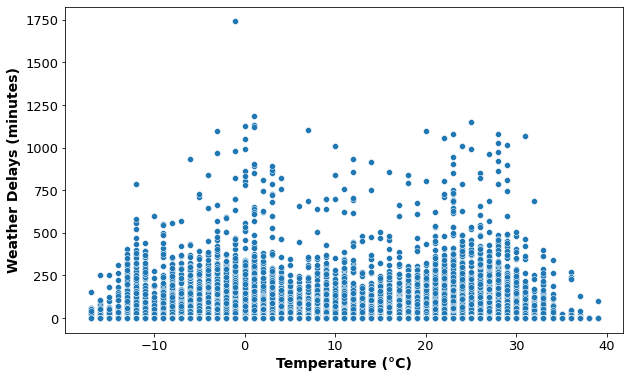

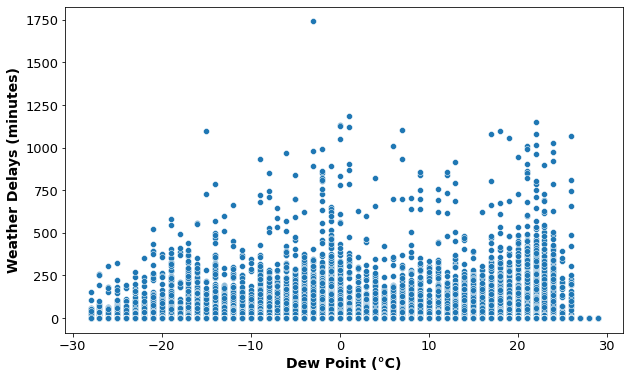

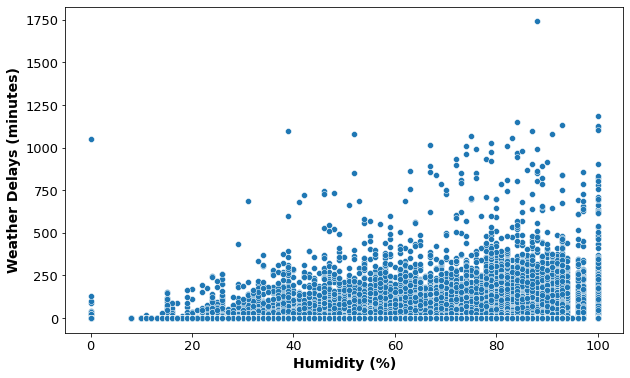

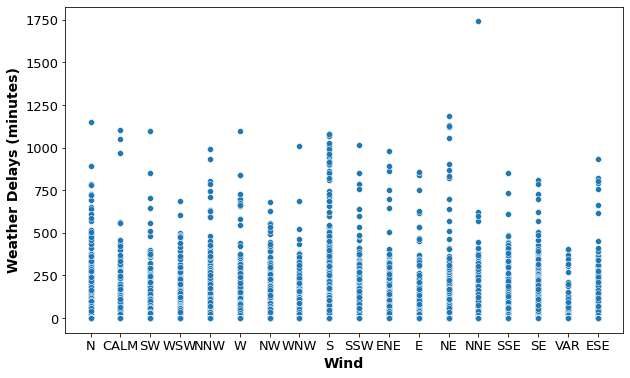

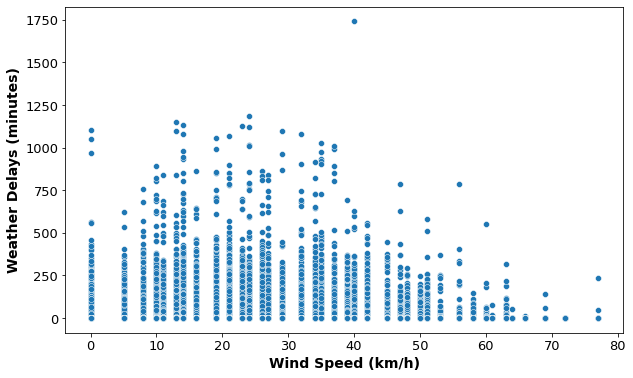

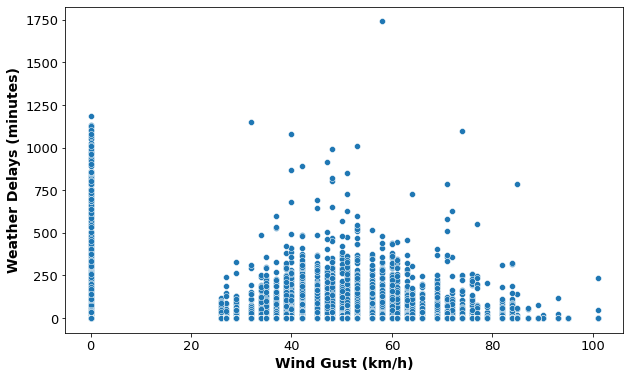

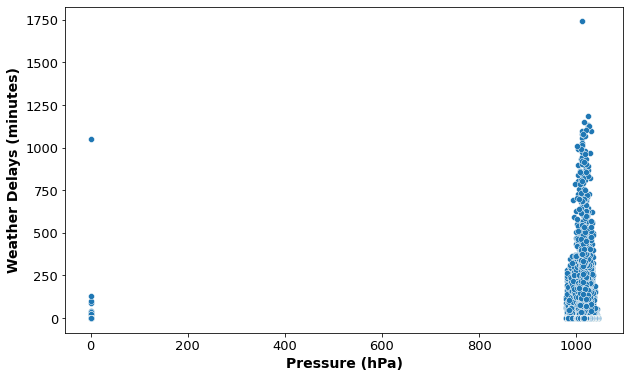

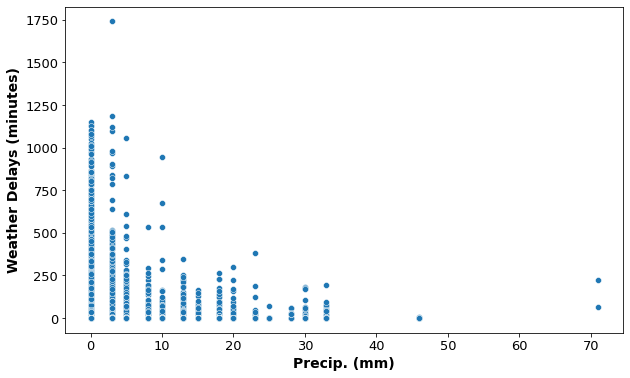

In [33]:
columns = ['Temperature (°C)', 'Dew Point (°C)', 'Humidity (%)','Wind', 'Wind Speed (km/h)', 'Wind Gust (km/h)', 'Pressure (hPa)','Precip. (mm)']
for column in columns:
    plt.figure(figsize=(10, 6))

    sns.scatterplot(x=df[column], y=df['WEATHER_DELAY'])

    # Axis configuration
    plt.xlabel(column, fontweight='bold', fontsize=14)
    plt.ylabel('Weather Delays (minutes)', fontweight='bold', fontsize=14)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)

    plt.show()

Influence of the weather on flight delays with weather score

In [34]:
def classify_temperature(temp):
    """
    Classifies temperatures with a score according to their influence on flight delays.
    The higher the score, the greater the influence of temperature on flight delays.

    Args:
        temp (int): Temperature in degrees Celsius.

    Returns:
        int: Temperature score
    """
    if 10 <= temp <= 20:
        return 0
    elif 0 <= temp < 10 or 20 < temp <= 30:
        return 1
    else:
        return 2

def classify_dew_point(dp):
    """
    Classifies dew point with a score according to their influence on flight delays.
    The higher the score, the greater the influence of dew point on flight delays.

    Args:
        dp (int): Dew point in degrees Celsius.

    Returns:
        int: Dew point score
    """
    if 10 <= dp <= 20:
        return 0
    elif 0 <= dp < 10 or 20 < dp <= 25:
        return 1
    else:
        return 2

def classify_humidity(hum):
    """
    Classifies humidity with a score according to their influence on flight delays.
    The higher the score, the greater the influence of humidity on flight delays.

    Args:
        hum (int): Humidity in percent.

    Returns:
        int: Humidity score
    """
    if 40 <= hum <= 60:
        return 0
    elif 30 <= hum < 40 or 60 < hum <= 70:
        return 1
    else:
        return 2
    
def classify_wind_speed(ws):
    """
    Classifies wind speed with a score according to their influence on flight delays.
    The higher the score, the greater the influence of wind speed on flight delays.

    Args:
        ws (int): Wind speed in km/h.

    Returns:
        int: Wind speed score 
    """
    if ws < 10:
        return 0
    elif 10 <= ws <= 20:
        return 1
    else:
        return 2

def classify_wind_gust(wg):
    """
    Classifies wind gust with a score according to their influence on flight delays.
    The higher the score, the greater the influence of wind gust on flight delays.

    Args:
        wg (int): Wind gust in km/h.

    Returns:
        int: Wind gust score 
    """
    if 20 < wg < 30:
        return 0
    elif 10 <= wg < 20 or 30 < wg <= 40:
        return 1
    else:
        return 2

def classify_pressure(press):
    """
    Classifies pressure with a score according to their influence on flight delays.
    The higher the score, the greater the influence of pressure on flight delays.

    Args:
        press (float): Pressure in hpa.

    Returns:
        int: Pressure score 
    """
    if 1012 <= press <= 1015:
        return 0
    elif 1000 <= press < 1012 or 1015 < press <= 1025:
        return 1
    else:
        return 2

def classify_precip(precip):
    """
    Classifies precipation with a score according to their influence on flight delays.
    The higher the score, the greater the influence of precipation on flight delays.

    Args:
        precip (int): Precipation in mm.

    Returns:
        int: Precipation score 
    """
    if precip == 0:
        return 0
    elif 0 < precip <= 10:
        return 1
    else:
        return 2

def classify_condition(cond):
    """
    Classifies weather condition with a score according to their influence on flight delays.
    The higher the score, the greater the influence of weather condition on flight delays.

    Args:
        cond (string): Weather condition.

    Returns:
        int: Weather condition score 
    """
    if cond in ['Fair', 'Fair / Windy', 'Partly Cloudy', 'Partly Cloudy / Windy']:
        return 0
    
    elif cond in ['Mostly Cloudy', 'Mostly Cloudy / Windy']:
        return 1
    
    elif cond in ['Cloudy', 'Cloudy / Windy']:
        return 2
    
    elif cond in ['Light Rain', 'Light Rain / Windy', 'Light Drizzle', 'Light Drizzle / Windy', 
                  'Drizzle', 'Haze', 'Mist', 'Smoke', 'Patches of Fog']:
        return 3
    
    elif cond in ['Rain', 'Rain / Windy']:
        return 4
    
    elif cond in ['Light Snow', 'Light Snow / Windy', 'Light Freezing Rain', 'Light Freezing Drizzle',
                  'Light Sleet', 'Rain and Sleet','Drizzle and Fog', 'Fog', 'Fog / Windy', 'Patches of Fog / Windy', 
                  'Shallow Fog', 'Snow and Sleet', 'Snow and Sleet / Windy', 'Haze / Windy', 'Mist / Windy', 
                  'Smoke / Windy']:
        return 5
    
    elif cond in ['Snow', 'Snow / Windy', 'Light Snow and Sleet', 'Light Snow and Sleet / Windy',
                  'Wintry Mix', 'Wintry Mix / Windy', 'Rain and Snow', 'Rain and Snow / Windy',
                  'Unknown Precipitation', 'Sleet', 'Sleet / Windy', 'Blowing Snow / Windy','Blowing Snow']:
        return 6

    elif cond in ['Heavy Rain', 'Heavy Rain / Windy', 'Squalls / Windy', 'Heavy Drizzle', 'Rain / Freezing Rain', 
                  'Snow / Freezing Rain', 'Light Snow / Freezing Rain','Heavy Snow', 'Heavy Snow / Windy', 
                  'Thunder in the Vicinity', 'Rain / Freezing Rain / Windy']:
        return 7
    
    elif cond in ['Light Rain with Thunder', 'Heavy T-Storm','Heavy T-Storm / Windy', 'T-Storm', 'T-Storm / Windy', 
                  'Thunder', 'Thunder / Windy','Thunder and Hail / Windy']:
        return 8

Calculating the weather score

In [35]:
def calculate_weather_score(row):
    """
    Calculates a score based on various weather conditions.
    
    Args:
        row (pd.Series): A row in the DataFrame containing the weather data for a flight.
    
    Returns:
        float: Normalised score for weather based on several criteria.
    """
    score = 0

    # Application of coefficients according to the importance of the scores
    score += (classify_temperature(row['Temperature (°C)'])/2) * 2 
    score += (classify_dew_point(row['Dew Point (°C)'])/2) * 2 
    score += (classify_humidity(row['Humidity (%)'])/2) * 4.5 
    score += (classify_wind_speed(row['Wind Speed (km/h)'])/2) * 3 
    score += (classify_wind_gust(row['Wind Gust (km/h)'])/2) * 4 
    score += (classify_pressure(row['Pressure (hPa)'])/2) * 3 
    score += (classify_precip(row['Precip. (mm)'])/2) * 4 
    score += (classify_condition(row['Condition'])/8) * 5 

    # Global weather score normalisation
    return score/27.5

df['Weather_Score'] = df.apply(calculate_weather_score, axis=1)

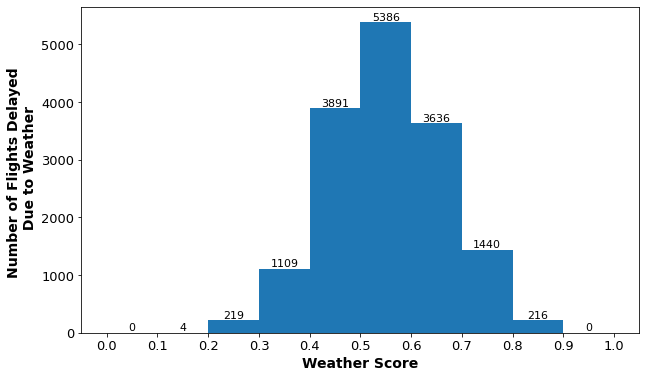

In [36]:
plt.figure(figsize=(10, 6))

bins = [i/10 for i in range(0, 11)]
number, bin, bars = plt.hist([df[df['STATUS'] == 2]['Weather_Score']], bins=bins)

# Axis configuration
plt.xlabel('Weather Score', fontweight='bold', fontsize=14)
plt.ylabel('Number of Flights Delayed \n Due to Weather', fontweight='bold', fontsize=14)
plt.xticks([i/10 for i in range(0, 11)], fontsize=13)
plt.yticks(fontsize=13)

# Define grid
plt.grid(True, linestyle='', alpha=0.7)

# Adding values above the bars    
for bar in bars.patches:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2.0, yval, int(yval), va='bottom', ha='center', fontsize=11)

plt.show()

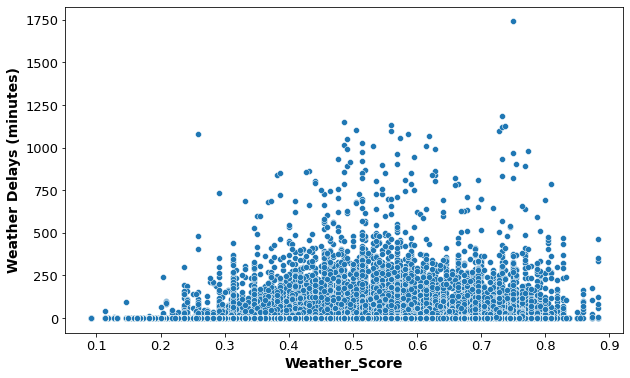

In [37]:
plt.figure(figsize=(10, 6))

sns.scatterplot(x=df["Weather_Score"], y=df['WEATHER_DELAY'])

# Axis configuration
plt.xlabel("Weather_Score", fontweight='bold', fontsize=14)
plt.ylabel('Weather Delays (minutes)', fontweight='bold', fontsize=14)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

### Data Encoding

In [38]:
def encode(df):
    """
    Encodes categorical and string columns using Label Encoding.
    
    Args:
        df (pd.DataFrame): A DataFrame containing columns to encode.
    
    Returns:
        pd.DataFrame: A DataFrame with encoded columns.
    """
    # Select columns of type category, object, string or datetime.
    columnsToEncode = list(df.select_dtypes(include=['category', 'object', 'string', 'datetime']))
    for feature in columnsToEncode:
        # Initialise the LabelEncoder
        le = LabelEncoder()
        print(feature)
        # Encode the column with LabelEncoder
        df[feature] = le.fit_transform(df[feature])
    return df

In [39]:
df = encode(df)
df

FL_DATE
OP_UNIQUE_CARRIER
TAIL_NUM
ORIGIN
DEST
Wind
Condition


,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS,Weather_Score
0,0,8,4756,6566,0,2,1840,1836.0,-4.0,0.0,...,0,76,4,10,0,1009.48,0,32,0,0.513636
1,0,4,3189,1297,0,4,600,557.0,-3.0,0.0,...,-1,92,0,0,0,1013.89,0,0,0,0.463636
2,0,4,4815,1641,0,4,820,845.0,25.0,1.0,...,0,93,13,5,0,1013.89,0,0,1,0.427273
3,0,4,4561,1723,0,4,1100,1053.0,-7.0,0.0,...,0,89,17,10,0,1012.87,0,0,0,0.481818
4,0,4,4963,1737,0,4,1350,1351.0,1.0,0.0,...,1,86,17,8,0,1011.18,0,32,0,0.459091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258492,4377,3,687,2725,0,87,1030,1028.0,-2.0,0.0,...,-4,53,8,23,0,1015.24,0,32,0,0.440909
1258493,4377,4,4320,1241,0,87,1133,1124.0,-9.0,0.0,...,-4,51,16,24,0,1015.92,0,32,0,0.440909
1258494,4377,3,949,125,0,87,1230,1231.0,1.0,0.0,...,-4,51,16,24,0,1015.24,0,32,0,0.440909
1258495,4377,3,2671,2825,0,87,1700,1657.0,-3.0,0.0,...,-4,51,15,19,0,1014.56,0,32,0,0.331818


### Data Normalisation

In [40]:
# List of columns to be normalised
features = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
       'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Temperature (°C)', 'Dew Point (°C)', 'Humidity (%)', 'Wind',
       'Wind Speed (km/h)', 'Wind Gust (km/h)', 'Pressure (hPa)',
       'Precip. (mm)', 'Condition']

# Creation of a MinMaxScaler object 
scaler = MinMaxScaler()

df[features] = scaler.fit_transform(df[features])
df

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS,Weather_Score
0,0.0,0.571429,0.886982,0.664070,0.0,0.022727,0.777635,0.778296,0.043455,0.0,...,0.491228,0.76,0.235294,0.129870,0.0,0.966602,0.0,0.533333,0,0.513636
1,0.0,0.285714,0.594741,0.131094,0.0,0.045455,0.246358,0.236117,0.043998,0.0,...,0.473684,0.92,0.000000,0.000000,0.0,0.970824,0.0,0.000000,0,0.463636
2,0.0,0.285714,0.897986,0.165891,0.0,0.045455,0.340617,0.358203,0.059207,1.0,...,0.491228,0.93,0.764706,0.064935,0.0,0.970824,0.0,0.000000,1,0.427273
3,0.0,0.285714,0.850615,0.174186,0.0,0.045455,0.460583,0.446376,0.041825,0.0,...,0.491228,0.89,1.000000,0.129870,0.0,0.969848,0.0,0.000000,0,0.481818
4,0.0,0.285714,0.925587,0.175602,0.0,0.045455,0.567695,0.572700,0.046171,0.0,...,0.508772,0.86,1.000000,0.103896,0.0,0.968229,0.0,0.533333,0,0.459091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1258492,1.0,0.214286,0.128124,0.275541,0.0,0.988636,0.430591,0.435778,0.044541,0.0,...,0.421053,0.53,0.470588,0.298701,0.0,0.972117,0.0,0.533333,0,0.440909
1258493,1.0,0.285714,0.805670,0.125430,0.0,0.988636,0.474722,0.476473,0.040739,0.0,...,0.421053,0.51,0.941176,0.311688,0.0,0.972768,0.0,0.533333,0,0.440909
1258494,1.0,0.214286,0.176986,0.012543,0.0,0.988636,0.516281,0.521831,0.046171,0.0,...,0.421053,0.51,0.941176,0.311688,0.0,0.972117,0.0,0.533333,0,0.440909
1258495,1.0,0.214286,0.498135,0.285656,0.0,0.988636,0.717652,0.702416,0.043998,0.0,...,0.421053,0.51,0.882353,0.246753,0.0,0.971466,0.0,0.533333,0,0.331818


### Data Split

In [41]:
# List of features
features = ['FL_DATE', 'OP_UNIQUE_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN', 'DEST', 'CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15',
       'TAXI_OUT', 'WHEELS_OFF', 'WHEELS_ON', 'TAXI_IN', 'CRS_ARR_TIME',
       'ARR_TIME', 'ARR_DELAY', 'ARR_DEL15', 'CRS_ELAPSED_TIME',
       'ACTUAL_ELAPSED_TIME', 'AIR_TIME', 'DISTANCE', 'CARRIER_DELAY',
       'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY',
       'Temperature (°C)', 'Dew Point (°C)', 'Humidity (%)', 'Wind',
       'Wind Speed (km/h)', 'Wind Gust (km/h)', 'Pressure (hPa)',
       'Precip. (mm)', 'Condition']

target = "STATUS"

# Divide data into training, validation and test sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

# DataFrame for training data
df_train = pd.DataFrame(X_train, columns=features)
df_train['STATUS'] = y_train

# DataFrame for validation data
df_val = pd.DataFrame(X_val, columns=features)
df_val['STATUS'] = y_val

# DataFrame for test data
df_test = pd.DataFrame(X_test, columns=features)
df_test['STATUS'] = y_test

In [42]:
df_train

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
797979,0.672378,0.214286,0.166169,0.011633,0.0,0.977273,0.304199,0.309029,0.042368,0.0,...,0.232143,0.228070,0.43,0.235294,0.142857,0.000000,0.994169,0.000000,0.066667,0
370630,0.306831,0.285714,0.089332,0.008699,0.0,0.045455,0.784062,0.785502,0.044541,0.0,...,0.750000,0.561404,0.26,0.411765,0.337662,0.386139,0.969848,0.000000,0.566667,0
627270,0.521819,0.214286,0.463633,0.058669,0.0,0.386364,0.607541,0.738448,0.142857,1.0,...,0.517857,0.684211,0.96,0.588235,0.519481,0.574257,0.954278,0.042254,0.366667,1
820508,0.688371,0.000000,0.073107,0.410075,0.0,0.215909,0.394173,0.397626,0.041825,0.0,...,0.357143,0.526316,0.93,0.705882,0.337662,0.000000,0.976330,0.000000,0.350000,0
744483,0.624629,0.285714,0.192093,0.281914,0.0,0.670455,0.656384,0.682493,0.052689,0.0,...,0.696429,0.877193,1.00,0.529412,0.311688,0.000000,0.969196,0.183099,0.250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1212612,0.969614,0.214286,0.196009,0.119765,0.0,0.761364,0.776778,0.776176,0.041825,0.0,...,0.767857,0.824561,0.66,0.529412,0.181818,0.000000,0.974712,0.000000,0.533333,0
14231,0.010966,0.928571,0.659642,0.723346,0.0,0.409091,0.599400,0.601526,0.042911,0.0,...,0.375000,0.421053,0.57,0.941176,0.480519,0.445545,0.958826,0.000000,0.550000,0
499099,0.413982,0.500000,0.585229,0.320453,0.0,0.647727,0.644816,0.652819,0.051059,0.0,...,0.357143,0.438596,0.67,0.470588,0.207792,0.000000,0.981845,0.000000,0.000000,1
299125,0.252684,0.071429,0.301194,0.041675,0.0,0.897727,0.259212,0.265791,0.043998,0.0,...,0.446429,0.631579,1.00,0.705882,0.142857,0.000000,0.972442,0.000000,0.000000,0


In [43]:
df_val

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
591666,0.490747,0.071429,0.296718,0.225470,0.0,0.556818,0.263496,0.268758,0.042368,0.0,...,0.535714,0.684211,0.84,1.000000,0.168831,0.000000,0.968545,0.0,0.533333,0
65986,0.050034,0.214286,0.626259,0.071819,0.0,0.477273,0.607541,0.610004,0.043455,0.0,...,0.821429,0.824561,0.53,0.647059,0.272727,0.000000,0.973410,0.0,0.566667,0
220795,0.185744,0.785714,0.443864,0.037629,0.0,0.227273,0.760497,0.744383,0.043455,0.0,...,0.482143,0.596491,0.77,0.352941,0.181818,0.000000,0.964007,0.0,0.533333,0
570213,0.472241,0.214286,0.157217,0.273215,0.0,0.159091,0.307626,0.312844,0.042911,0.0,...,0.696429,0.859649,0.91,0.705882,0.064935,0.000000,0.973735,0.0,0.566667,0
166716,0.135709,0.214286,0.583737,0.004248,0.0,0.534091,0.897601,0.990674,0.120043,1.0,...,0.696429,0.807018,0.78,1.000000,0.181818,0.000000,0.971140,0.0,0.533333,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200635,0.167466,0.214286,0.145468,0.102064,0.0,0.125000,0.591260,0.575244,0.041282,0.0,...,0.375000,0.350877,0.43,0.941176,0.311688,0.366337,0.967578,0.0,0.533333,0
541360,0.449623,0.285714,0.257180,0.049059,0.0,0.477273,0.430591,0.433658,0.041825,0.0,...,0.696429,0.754386,0.64,0.529412,0.181818,0.000000,0.979902,0.0,0.566667,0
547170,0.454192,0.214286,0.441813,0.008295,0.0,0.534091,0.519709,0.524799,0.045627,0.0,...,0.732143,0.877193,0.89,0.000000,0.000000,0.000000,0.970499,0.0,0.000000,0
704483,0.588988,0.214286,0.403021,0.014971,0.0,0.738636,0.760497,0.763035,0.045627,0.0,...,0.446429,0.421053,0.41,0.941176,0.610390,0.653465,0.954278,0.0,0.583333,0


In [44]:
df_test

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
1086807,0.890564,0.000000,0.162066,0.472891,0.0,0.306818,0.271637,0.276812,0.042368,0.0,...,0.625000,0.736842,0.75,0.235294,0.129870,0.000000,0.970499,0.0,0.533333,0
701389,0.586018,0.214286,0.554644,0.016387,0.0,0.943182,0.261782,0.266638,0.041825,0.0,...,0.535714,0.649123,0.75,0.882353,0.272727,0.000000,0.978599,0.0,0.566667,0
1205858,0.965273,0.214286,0.969787,0.184301,0.0,0.488636,0.863325,0.867741,0.049430,0.0,...,0.714286,0.719298,0.55,0.529412,0.103896,0.000000,0.976656,0.0,0.533333,0
881871,0.727439,0.214286,0.939015,0.242768,0.0,0.352273,0.571551,0.575668,0.045084,0.0,...,0.660714,0.719298,0.65,0.058824,0.376623,0.000000,0.987677,0.0,0.533333,0
706838,0.591273,0.214286,0.404513,0.111268,0.0,0.352273,0.737361,0.743959,0.050516,0.0,...,0.392857,0.421053,0.53,0.764706,0.298701,0.000000,0.967904,0.0,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932174,0.777245,0.071429,0.025923,0.002731,0.0,0.488636,0.760497,0.763035,0.045627,0.0,...,0.625000,0.456140,0.25,0.882353,0.506494,0.623762,0.956232,0.0,0.550000,0
943169,0.788440,0.285714,0.182768,0.047239,0.0,0.352273,0.828620,0.848665,0.047257,0.0,...,0.696429,0.771930,0.68,0.529412,0.441558,0.000000,0.968545,0.0,0.550000,0
278608,0.234864,0.714286,0.058187,0.112988,0.0,0.488636,0.246358,0.236965,0.045084,0.0,...,0.571429,0.701754,0.83,0.294118,0.103896,0.000000,0.979250,0.0,0.000000,0
93641,0.071510,0.071429,0.267065,0.008497,0.0,0.875000,0.644816,0.647732,0.044541,0.0,...,0.535714,0.543860,0.49,0.235294,0.298701,0.346535,0.974061,0.0,0.533333,0


### Sampling Techniques

In [45]:
df_train['STATUS'].value_counts()

0    547601
1    148250
2      8906
Name: STATUS, dtype: int64

In [46]:
# Creation of an instance of SMOTE with a specific random string for reproducibility
smote = SMOTE(random_state=RANDOM_SEED)

# Application of SMOTE to resample training data in order to balance the data
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Creation of a DataFrame with the resampled data
df_train_resampled = pd.DataFrame(X_train_resampled, columns=features)
df_train_resampled['STATUS'] = y_train_resampled
df_train_resampled

,FL_DATE,OP_UNIQUE_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN,DEST,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,...,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
0,0.672378,0.214286,0.166169,0.011633,0.0,0.977273,0.304199,0.309029,0.042368,0.0,...,0.232143,0.228070,0.430000,0.235294,0.142857,0.000000,0.994169,0.000000,0.066667,0
1,0.306831,0.285714,0.089332,0.008699,0.0,0.045455,0.784062,0.785502,0.044541,0.0,...,0.750000,0.561404,0.260000,0.411765,0.337662,0.386139,0.969848,0.000000,0.566667,0
2,0.521819,0.214286,0.463633,0.058669,0.0,0.386364,0.607541,0.738448,0.142857,1.0,...,0.517857,0.684211,0.960000,0.588235,0.519481,0.574257,0.954278,0.042254,0.366667,1
3,0.688371,0.000000,0.073107,0.410075,0.0,0.215909,0.394173,0.397626,0.041825,0.0,...,0.357143,0.526316,0.930000,0.705882,0.337662,0.000000,0.976330,0.000000,0.350000,0
4,0.624629,0.285714,0.192093,0.281914,0.0,0.670455,0.656384,0.682493,0.052689,0.0,...,0.696429,0.877193,1.000000,0.529412,0.311688,0.000000,0.969196,0.183099,0.250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642798,0.303123,0.216897,0.153016,0.107602,0.0,0.645918,0.655370,0.690537,0.064281,1.0,...,0.714286,0.859649,0.870366,0.762556,0.204944,0.000000,0.970333,0.000000,0.533333,2
1642799,0.427503,0.071429,0.310825,0.008396,0.0,0.125000,0.302057,0.363547,0.088085,1.0,...,0.185015,0.326262,0.824165,0.224681,0.138894,0.000000,0.972355,0.000000,0.420601,2
1642800,0.869774,0.071429,0.948734,0.242170,0.0,0.268599,0.260510,0.301502,0.066384,1.0,...,0.667748,0.842105,0.984245,0.529412,0.393930,0.187188,0.959724,0.102012,0.738367,2
1642801,0.476784,0.857143,0.360151,0.040583,0.0,0.488636,0.326125,0.333009,0.045297,0.0,...,0.367843,0.438596,0.640041,0.399856,0.192229,0.000000,0.979981,0.000000,0.566667,2


In [47]:
df_train_resampled['STATUS'].value_counts()

0    547601
1    547601
2    547601
Name: STATUS, dtype: int64

### Feature selection

In [48]:
# List of relevant columns to be retained in the DataFrame before selection
relevant_columns = ['FL_DATE','CRS_DEP_TIME', 'DEP_TIME', 'DEP_DELAY', 'DEP_DEL15','TAXI_OUT', 'WHEELS_OFF', 'CRS_ARR_TIME',
                    'CRS_ELAPSED_TIME', 'DISTANCE','Temperature (°C)', 'Dew Point (°C)', 'Humidity (%)', 'Wind',
                    'Wind Speed (km/h)', 'Wind Gust (km/h)', 'Pressure (hPa)','Precip. (mm)', 'Condition', 
                    'STATUS']

df_train_resampled = df_train_resampled[relevant_columns]
df_train_resampled

,FL_DATE,CRS_DEP_TIME,DEP_TIME,DEP_DELAY,DEP_DEL15,TAXI_OUT,WHEELS_OFF,CRS_ARR_TIME,CRS_ELAPSED_TIME,DISTANCE,Temperature (°C),Dew Point (°C),Humidity (%),Wind,Wind Speed (km/h),Wind Gust (km/h),Pressure (hPa),Precip. (mm),Condition,STATUS
0,0.672378,0.304199,0.309029,0.042368,0.0,0.135135,0.320051,0.359474,0.059226,0.023522,0.232143,0.228070,0.430000,0.235294,0.142857,0.000000,0.994169,0.000000,0.066667,0
1,0.306831,0.784062,0.785502,0.044541,0.0,0.124324,0.812632,0.903349,0.122248,0.136224,0.750000,0.561404,0.260000,0.411765,0.337662,0.386139,0.969848,0.000000,0.566667,0
2,0.521819,0.607541,0.738448,0.142857,1.0,0.070270,0.744383,0.740144,0.188307,0.272857,0.517857,0.684211,0.960000,0.588235,0.519481,0.574257,0.954278,0.042254,0.366667,1
3,0.688371,0.394173,0.397626,0.041825,0.0,0.091892,0.405256,0.484951,0.094153,0.067703,0.357143,0.526316,0.930000,0.705882,0.337662,0.000000,0.976330,0.000000,0.350000,0
4,0.624629,0.656384,0.682493,0.052689,0.0,0.362162,0.728275,0.810089,0.151101,0.191041,0.696429,0.877193,1.000000,0.529412,0.311688,0.000000,0.969196,0.183099,0.250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642798,0.303123,0.655370,0.690537,0.064281,1.0,0.250893,0.726973,0.742318,0.133923,0.138548,0.714286,0.859649,0.870366,0.762556,0.204944,0.000000,0.970333,0.000000,0.533333,2
1642799,0.427503,0.302057,0.363547,0.088085,1.0,0.281455,0.403000,0.356507,0.057707,0.019022,0.185015,0.326262,0.824165,0.224681,0.138894,0.000000,0.972355,0.000000,0.420601,2
1642800,0.869774,0.260510,0.301502,0.066384,1.0,0.118753,0.311239,0.374391,0.142202,0.196810,0.667748,0.842105,0.984245,0.529412,0.393930,0.187188,0.959724,0.102012,0.738367,2
1642801,0.476784,0.326125,0.333009,0.045297,0.0,0.127541,0.343435,0.468068,0.290809,0.487012,0.367843,0.438596,0.640041,0.399856,0.192229,0.000000,0.979981,0.000000,0.566667,2


                    FL_DATE  CRS_DEP_TIME  DEP_TIME  DEP_DELAY  DEP_DEL15  \
FL_DATE            1.000000     -0.062307 -0.041881  -0.005557  -0.042564   
CRS_DEP_TIME      -0.062307      1.000000  0.701107   0.209199   0.248688   
DEP_TIME          -0.041881      0.701107  1.000000   0.057263   0.223023   
DEP_DELAY         -0.005557      0.209199  0.057263   1.000000   0.563475   
DEP_DEL15         -0.042564      0.248688  0.223023   0.563475   1.000000   
TAXI_OUT          -0.096060      0.156909  0.222431   0.108859   0.182597   
WHEELS_OFF        -0.021821      0.564340  0.832192  -0.020447   0.161237   
CRS_ARR_TIME      -0.044427      0.443207  0.493939   0.121912   0.113713   
CRS_ELAPSED_TIME  -0.021652     -0.007416  0.036495  -0.027705  -0.057313   
DISTANCE          -0.022330     -0.032021  0.000780  -0.036578  -0.066766   
Temperature (°C)   0.033451      0.143088  0.105250   0.003906  -0.037919   
Dew Point (°C)     0.060136      0.105616  0.055475   0.078973   0.043159   

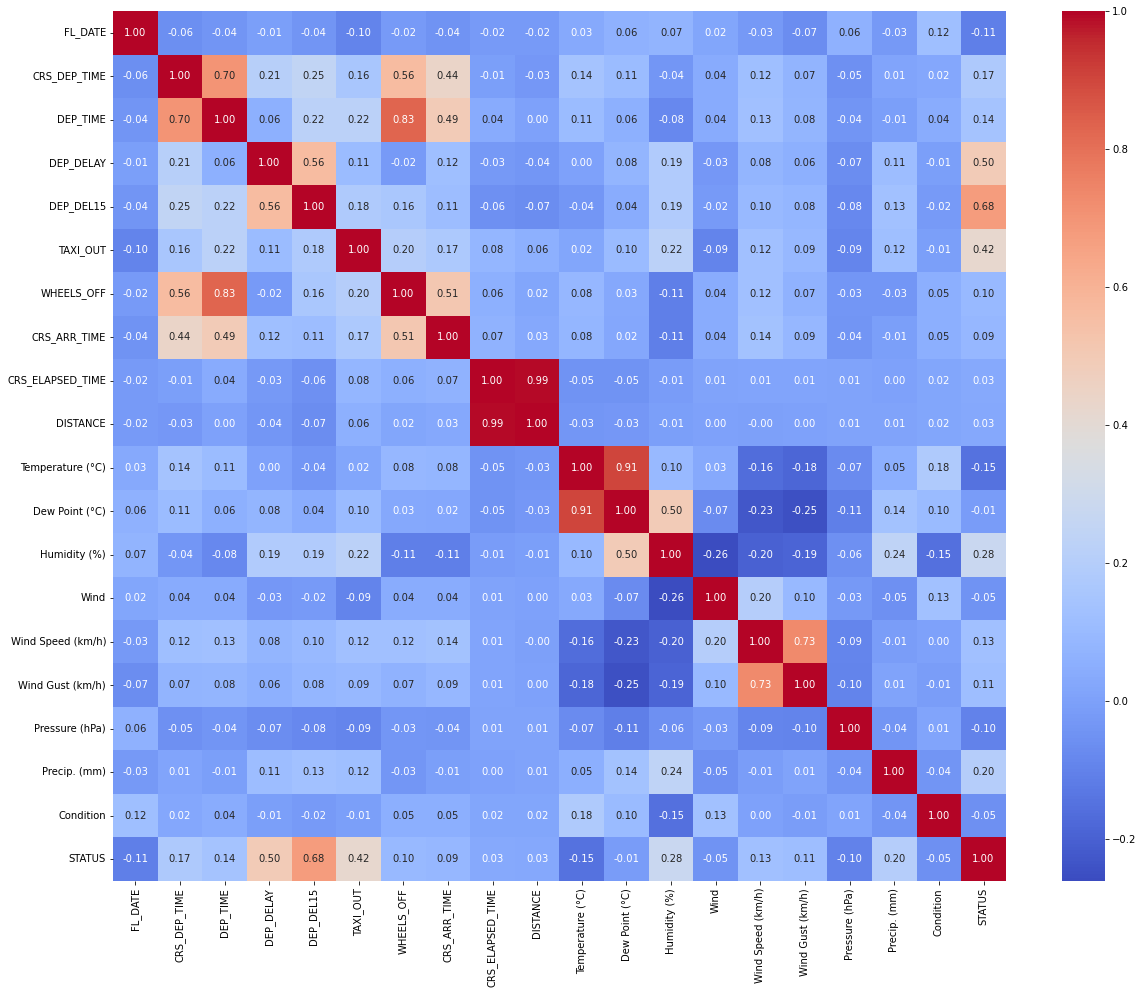

In [49]:
plt.figure(figsize=(20, 16))

# Correlation matrix
corr_matrix = df_train_resampled.corr()
print(corr_matrix)

# Heat map of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

In [50]:
# Separate features and target variable
X_feature_selection = df_train_resampled.drop(columns=['STATUS'])
y_feature_selection = df_train_resampled['STATUS']

# Use the mutual information score to determine the relationships between features and the target variable
selector = SelectKBest(score_func=mutual_info_classif, k='all')
X_results = selector.fit_transform(X_feature_selection, y_feature_selection)

# Display scores
mutual_info_scores = pd.DataFrame({'Feature': X_feature_selection.columns, 'Score': selector.scores_})
print(mutual_info_scores.sort_values(by='Score', ascending=False))

              Feature     Score
3           DEP_DELAY  0.585427
6          WHEELS_OFF  0.479746
5            TAXI_OUT  0.476312
2            DEP_TIME  0.473587
0             FL_DATE  0.469629
7        CRS_ARR_TIME  0.427120
4           DEP_DEL15  0.419191
8    CRS_ELAPSED_TIME  0.405782
16     Pressure (hPa)  0.400007
1        CRS_DEP_TIME  0.392476
12       Humidity (%)  0.391921
10   Temperature (°C)  0.370352
11     Dew Point (°C)  0.352480
14  Wind Speed (km/h)  0.336234
9            DISTANCE  0.257649
18          Condition  0.250349
13               Wind  0.236812
15   Wind Gust (km/h)  0.080460
17       Precip. (mm)  0.066648


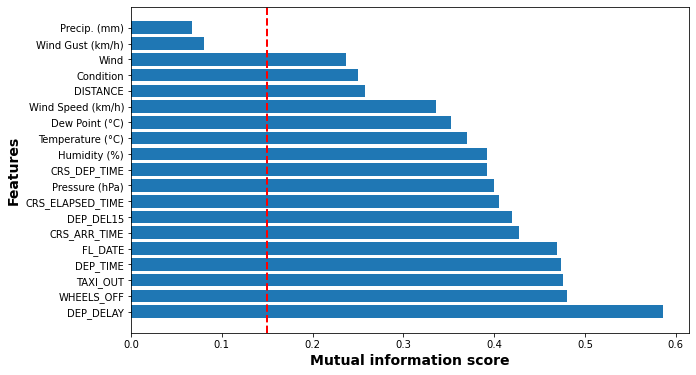

In [51]:
# Sort scores in descending order
mutual_info_scores = mutual_info_scores.sort_values(by='Score', ascending=False)

# Horizontal bar chart with features and their mutual information scores
plt.figure(figsize=(10, 6))
plt.barh(mutual_info_scores["Feature"], mutual_info_scores["Score"])

# Axis configuration
plt.xlabel('Mutual information score', fontsize=14, fontweight='bold')
plt.ylabel('Features', fontsize=14, fontweight='bold')

# Mutual information score threshold
plt.axvline(x=0.15, color='red', linestyle='--', linewidth=2) 

plt.show()

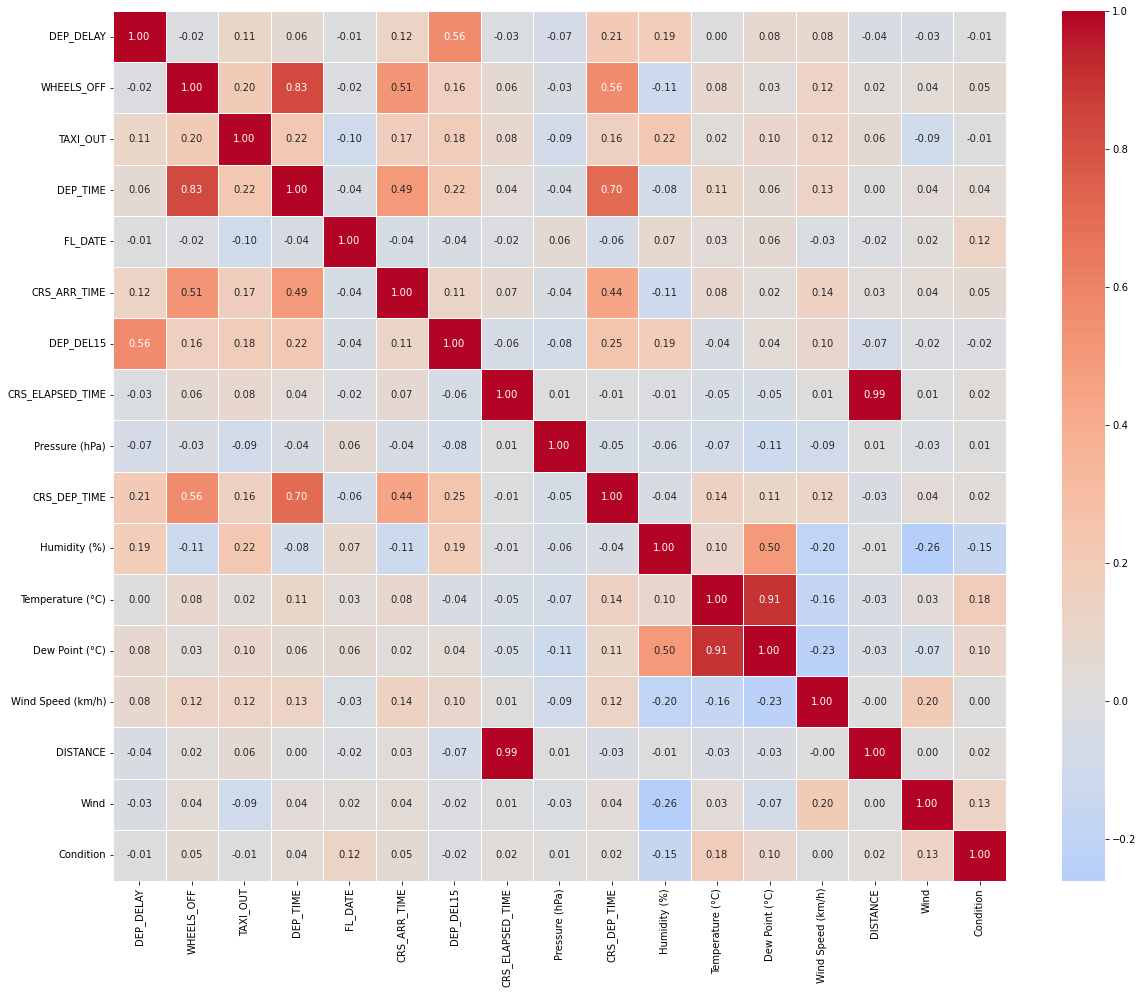

          Feature 1       Feature 2  Correlation Coefficient
0        WHEELS_OFF        DEP_TIME                 0.832192
2  CRS_ELAPSED_TIME        DISTANCE                 0.993380
3  Temperature (°C)  Dew Point (°C)                 0.905055


In [52]:
# Features with a score of more than 0.2 are retained.
features = ['DEP_DELAY', 'WHEELS_OFF', 'TAXI_OUT', 'DEP_TIME', 'FL_DATE', 'CRS_ARR_TIME', 'DEP_DEL15', 
            'CRS_ELAPSED_TIME', 'Pressure (hPa)','CRS_DEP_TIME', 'Humidity (%)','Temperature (°C)',
            'Dew Point (°C)','Wind Speed (km/h)','DISTANCE','Wind','Condition']

# Correlation matrix for selected features
corr_matrix = df_train_resampled[features].corr()

plt.figure(figsize=(20, 16))

# Heat map of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', center=0, linewidths=.5)
plt.show()

# Selection of feature pairs with an absolute correlation greater than 0.8
high_corr = corr_matrix[((corr_matrix >= 0.8) & (corr_matrix < 1.00)) | ((corr_matrix <= -0.8) & (corr_matrix <= -1.00))]
high_corr = high_corr.dropna(how='all', axis=0).dropna(how='all', axis=1)

# Transformation of the correlation matrix into a DataFrame 
high_corr_unstacked = high_corr.unstack().dropna().reset_index()
high_corr_unstacked.columns = ['Feature 1', 'Feature 2', 'Correlation Coefficient']

# Store pairs of highly correlated features
high_corr_unstacked['Ordered Features'] = high_corr_unstacked.apply(lambda row: tuple(sorted([row['Feature 1'], row['Feature 2']])), axis=1)

# Delete duplicate pairs
high_corr_unstacked = high_corr_unstacked.drop_duplicates(subset='Ordered Features').drop(columns='Ordered Features')

print(high_corr_unstacked)

In [53]:
# Features selected for training and evaluation of models
features = ['DEP_DELAY', 'WHEELS_OFF', 'TAXI_OUT', 'FL_DATE', 'CRS_ARR_TIME', 'DEP_DEL15', 
            'CRS_ELAPSED_TIME', 'Pressure (hPa)','CRS_DEP_TIME', 'Humidity (%)','Temperature (°C)'
            ,'Wind Speed (km/h)','Wind','Condition']

target = 'STATUS'

In [54]:
df_train_resampled = df_train_resampled[features + [target]]
df_val = df_val[features + [target]]
df_test = df_test[features + [target]]

In [55]:
df_train_resampled

,DEP_DELAY,WHEELS_OFF,TAXI_OUT,FL_DATE,CRS_ARR_TIME,DEP_DEL15,CRS_ELAPSED_TIME,Pressure (hPa),CRS_DEP_TIME,Humidity (%),Temperature (°C),Wind Speed (km/h),Wind,Condition,STATUS
0,0.042368,0.320051,0.135135,0.672378,0.359474,0.0,0.059226,0.994169,0.304199,0.430000,0.232143,0.142857,0.235294,0.066667,0
1,0.044541,0.812632,0.124324,0.306831,0.903349,0.0,0.122248,0.969848,0.784062,0.260000,0.750000,0.337662,0.411765,0.566667,0
2,0.142857,0.744383,0.070270,0.521819,0.740144,1.0,0.188307,0.954278,0.607541,0.960000,0.517857,0.519481,0.588235,0.366667,1
3,0.041825,0.405256,0.091892,0.688371,0.484951,0.0,0.094153,0.976330,0.394173,0.930000,0.357143,0.337662,0.705882,0.350000,0
4,0.052689,0.728275,0.362162,0.624629,0.810089,0.0,0.151101,0.969196,0.656384,1.000000,0.696429,0.311688,0.529412,0.250000,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1642798,0.064281,0.726973,0.250893,0.303123,0.742318,1.0,0.133923,0.970333,0.655370,0.870366,0.714286,0.204944,0.762556,0.533333,2
1642799,0.088085,0.403000,0.281455,0.427503,0.356507,1.0,0.057707,0.972355,0.302057,0.824165,0.185015,0.138894,0.224681,0.420601,2
1642800,0.066384,0.311239,0.118753,0.869774,0.374391,1.0,0.142202,0.959724,0.260510,0.984245,0.667748,0.393930,0.529412,0.738367,2
1642801,0.045297,0.343435,0.127541,0.476784,0.468068,0.0,0.290809,0.979981,0.326125,0.640041,0.367843,0.192229,0.399856,0.566667,2


In [56]:
df_val

,DEP_DELAY,WHEELS_OFF,TAXI_OUT,FL_DATE,CRS_ARR_TIME,DEP_DEL15,CRS_ELAPSED_TIME,Pressure (hPa),CRS_DEP_TIME,Humidity (%),Temperature (°C),Wind Speed (km/h),Wind,Condition,STATUS
591666,0.042368,0.276812,0.097297,0.490747,0.426452,0.0,0.160213,0.968545,0.263496,0.84,0.535714,0.168831,1.000000,0.533333,0
65986,0.043455,0.636287,0.113514,0.050034,0.733362,0.0,0.267274,0.973410,0.607541,0.53,0.821429,0.272727,0.647059,0.566667,0
220795,0.043455,0.768970,0.091892,0.185744,0.850360,0.0,0.099468,0.964007,0.760497,0.77,0.482143,0.181818,0.352941,0.533333,0
570213,0.042911,0.342942,0.162162,0.472241,0.385333,0.0,0.069096,0.973735,0.307626,0.91,0.696429,0.064935,0.705882,0.566667,0
166716,0.120043,0.006359,0.200000,0.135709,0.004239,1.0,0.132878,0.971140,0.897601,0.78,0.696429,0.181818,1.000000,0.533333,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200635,0.041282,0.597287,0.059459,0.167466,0.642221,0.0,0.056948,0.967578,0.591260,0.43,0.375000,0.311688,0.941176,0.533333,0
541360,0.041825,0.442984,0.113514,0.449623,0.551929,0.0,0.255885,0.979902,0.430591,0.64,0.696429,0.181818,0.529412,0.566667,0
547170,0.045627,0.532853,0.097297,0.454192,0.648580,0.0,0.134396,0.970499,0.519709,0.89,0.732143,0.000000,0.000000,0.000000,0
704483,0.045627,0.781263,0.227027,0.588988,0.892327,0.0,0.280942,0.954278,0.760497,0.41,0.446429,0.610390,0.941176,0.583333,0


In [57]:
df_test

,DEP_DELAY,WHEELS_OFF,TAXI_OUT,FL_DATE,CRS_ARR_TIME,DEP_DEL15,CRS_ELAPSED_TIME,Pressure (hPa),CRS_DEP_TIME,Humidity (%),Temperature (°C),Wind Speed (km/h),Wind,Condition,STATUS
1086807,0.042368,0.300975,0.086486,0.890564,0.384485,0.0,0.100987,0.970499,0.271637,0.75,0.625000,0.129870,0.235294,0.533333,0
701389,0.041825,0.275540,0.108108,0.586018,0.400593,0.0,0.147304,0.978599,0.261782,0.75,0.535714,0.272727,0.882353,0.566667,0
1205858,0.049430,0.891056,0.075676,0.965273,0.998304,0.0,0.288535,0.976656,0.863325,0.55,0.714286,0.103896,0.529412,0.533333,0
881871,0.045084,0.598983,0.075676,0.727439,0.703264,0.0,0.140471,0.987677,0.571551,0.65,0.660714,0.376623,0.058824,0.533333,0
706838,0.050516,0.769818,0.108108,0.591273,0.890208,0.0,0.151101,0.967904,0.737361,0.53,0.392857,0.298701,0.764706,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
932174,0.045627,0.774905,0.145946,0.777245,0.903773,0.0,0.301443,0.956232,0.760497,0.25,0.625000,0.506494,0.882353,0.550000,0
943169,0.047257,0.858415,0.118919,0.788440,0.986435,0.0,0.161731,0.968545,0.828620,0.68,0.696429,0.441558,0.529412,0.550000,0
278608,0.045084,0.261552,0.091892,0.234864,0.381518,0.0,0.277145,0.979250,0.246358,0.83,0.571429,0.103896,0.294118,0.000000,0
93641,0.044541,0.655786,0.097297,0.071510,0.784231,0.0,0.292331,0.974061,0.644816,0.49,0.535714,0.298701,0.235294,0.533333,0


In [58]:
# Saving data
df_train_resampled.to_csv(f"Chandrakumar_s419255_Training_Data_MScCSTE/Training_Dataset_{timing}h.csv",index=False) 
df_val.to_csv(f"Chandrakumar_s419255_Validation_Data_MScCSTE/Validation_Dataset_{timing}h.csv",index=False) 
df_test.to_csv(f"Chandrakumar_s419255_Testing_Data_MScCSTE/Testing_Dataset_{timing}h.csv",index=False) 